In [1]:
!pwd
!python --version
!which python

/home/shpaik/22-acml2022/Fig3
Python 3.6.10 :: Anaconda, Inc.
/home/shpaik/anaconda3/envs/py36/bin/python


In [2]:
import os
current_dir = os.getcwd()
print(current_dir)

# control the maximum number of threads that numpy uses by 8
os.environ["OMP_NUM_THREADS"] = "8" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "8" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "8" # export NUMEXPR_NUM_THREADS=6

/home/shpaik/22-acml2022/Fig3


In [3]:
os.chdir("../")
from lib_external.SCLUB import SCLUB
from lib_external.DyClu import DyClu
os.chdir(current_dir)

%run SYNTH_functions.ipynb

In [4]:
import numpy as np 
import networkx as nx
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import Normalizer, MinMaxScaler
from scipy.sparse import csgraph 
import scipy
import os
import random
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
import time
from datetime import datetime

In [5]:
plt.style.use("ggplot")

[]

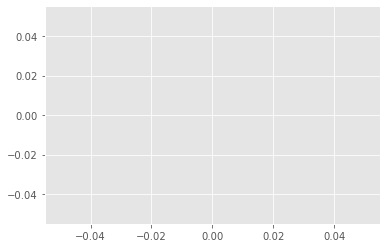

In [6]:
plt.figure()
plt.plot()

In [7]:
tuning_simul_n = 1
simul_n=1
tuning_time_horizon = 1

const_R = 0.1
delta = 0.05

v = 10
lam = 10

epsilon = 1
threshold = 0.5
prob = 0.4

lap_type = "random_walk"
our_graph_type = "ER" 

##### For DyClu (default option) ####
dyclu_options = {
    'tau_e': 20, # size of sliding window,
    'alpha': 0.3,
    'delta_1': 1e-1,
    'delta_2': 1e-1,
    'change_detection_alpha': 0.01,
    'neighbor_identification_alpha': 0.01 ,
    'dataSharing': False, 
    'aggregationMethod': 'combine',
    'useOutdated': True ,
    'maxNumOutdatedModels': None, 
}

nu_type = "0"
arm_type = "sparse"

const_alpha_2 = 0.15

In [8]:
for_final_plot_dict = {"user_num" : {}, "dimension" : {}, "arm_num": {}}
record_for_final_plot_dict = {"user_num" : {}, "dimension" : {}, "arm_num": {}}

In [9]:
colors_dict = {"Random": "gold",
               "RGraphTS" : "r",
               "LinTS" : "g",
               "SemiRGraphTS" : "blue",
               "GraphUCBlocal" : "brown",
               "CLUB" : "slategrey",
               "SCLUB" : "r",
               "DyClu" : "aqua",
               "IndividualSemiRidgeGraphThompson" : "pink",
               "LinTS_Single" : "lime",
               "SemiTS_Single": "m"}

labels_dict = {"Random": "Random",
               "RGraphTS" : "Proposed-Stationary",
               "LinTS" : "LinTS-Ind",
               "SemiRGraphTS" : "Proposed",
               "GraphUCBlocal" : "GraphUCB",
               "CLUB" : "CLUB",
               "SCLUB" : "SCLUB",
               "DyClu" : "DyClu",
               "IndividualSemiRidgeGraphThompson" : "SemiTS-Ind",
               "LinTS_Single" : "LinTS-Sin",
               "SemiTS_Single": "SemiTS-Sin"}

In [10]:
diff_var = {"user_num" : [30, 60, 120, 240, 480, 960, 1920],
            "dimension" :  [10, 20, 40, 80, 160, 320, 640, 1280],
            "arm_num":[8, 15, 30, 90, 180, 360, 720]
           }
time_horizon = 100

# 1. Change user_num

In [11]:
# base: setting (i)
arm_num = 10
change_dict = {}
change_dict["user_num"] = diff_var["user_num"]
change_dict["dimension"] = [40]
change_dict["gamma"] = [5]

change_val_name = "user_num" # just base value, no meaning
for key, val in change_dict.items():
    if len(val) > 1: # only one of "user_num", "dimension", "gamma" has the value with length > 1
        change_val_name = key
print(f"change_val_name = {change_val_name}")

#model_list=["SemiRGraphTS", "IndividualSemiRidgeGraphThompson", "SemiTS_Single", "GraphUCBlocal", "CLUB",  "LinTS", "LinTS_Single", "Random"]
model_list=["SemiRGraphTS", "IndividualSemiRidgeGraphThompson", "SemiTS_Single", "GraphUCBlocal", "SCLUB", "DyClu",  "LinTS", "LinTS_Single", "Random"]
runtime_dict={model:{i:0 for i in change_dict[change_val_name]} for model in model_list}
record_runtime_dict = {model:{i:[] for i in change_dict[change_val_name]} for model in model_list}

change_val_name = user_num


In [12]:
for user_num in change_dict["user_num"]:
    for dimension in change_dict["dimension"]:
        for gamma in change_dict["gamma"]: # only one of {user_num, dimension, gamma} is changing
            
            print(f"\nchange_val = {change_val_name} // user_num = {user_num} / dimension = {dimension} / gamma = {gamma}\n")
            #time.sleep(3)
            
            const_tol_1 = dimension
            const_tol_2 = const_tol_1 * 1e-5 

            # which value is changing?
            if change_val_name == "user_num":
                change_val = user_num
            elif change_val_name == "dimension":
                change_val = dimension
            elif change_val == "gamma":
                change_val = gamma
                
            # save runtime of each algorithms (as changing change_val)                
            if change_val_name == "gamma":
                pass        
            else:
                our_graph, our_laplacian, users_features, symm_laplacian = set_graph_and_lapl_for_experiment(user_num, dimension, prob, threshold, our_graph_type, lap_type, gamma)

                best_v_lam_pair_dict = {} # fix any v and lam as best pair (because we only want to know the computation time per round)
                for model in model_list:
                    best_v_lam_pair_dict[model] = {"v": v, "lam": lam} 

                cumulated_regret_dict, info_computing_time, info_computing_time_dict, record_runtime = RUNTIME_for_selected_model_SYNTH(model_list,\
                                                                                                                        best_v_lam_pair_dict, user_num, arm_num, dimension, time_horizon, const_R, delta, simul_n, epsilon, threshold, prob, gamma, our_graph, our_laplacian, symm_laplacian, const_alpha_2, const_tol_1, const_tol_2, nu_type, arm_type)
                
                # save in runtime_dict
                for model in model_list:
                    runtime_dict[model][change_val] = info_computing_time_dict[model]
                    record_runtime_dict[model][change_val] = record_runtime[model]


change_val = user_num // user_num = 30 / dimension = 40 / gamma = 5

<set models>
IndTS, time = 0.004038095474243164 sec
SCLUB, time = 0.003261089324951172 sec
DyClu, time = 0.0003445148468017578 sec
SemiRidegeTS, time = 0.0025179386138916016 sec
GUCBlocal, time = 0.004195690155029297 sec
IndividualSemiRidgeGraphThompson, time = 0.002145528793334961 sec
LinTS_Single, time = 0.000762939453125 sec
SemiTS_Single, time = 0.0006577968597412109 sec
0 user: 5 / selected arms: 8 -1 8 5 -1 -1 5 0 3 6 4 1 / opt_arm: 9 / time : 0.033 sec
=====
10 user: 26 / selected arms: 6 -1 7 1 -1 -1 1 9 3 2 1 4 / opt_arm: 6 / time : 0.033 sec
=====
20 user: 27 / selected arms: 6 -1 1 4 -1 -1 4 7 9 9 5 5 / opt_arm: 0 / time : 0.036 sec
=====
30 user: 4 / selected arms: 0 -1 4 4 -1 -1 4 0 3 8 2 4 / opt_arm: 9 / time : 0.039 sec
=====
40 user: 1 / selected arms: 5 -1 1 8 -1 -1 8 3 9 0 1 8 / opt_arm: 9 / time : 0.035 sec
=====
50 user: 11 / selected arms: 7 -1 9 2 -1 -1 2 8 3 8 9 1 / opt_arm: 7 / time : 0.036 se

In [13]:
for_final_plot_dict[change_val_name] = runtime_dict
record_for_final_plot_dict[change_val_name] = record_runtime_dict

In [14]:
# record_runtime_dict

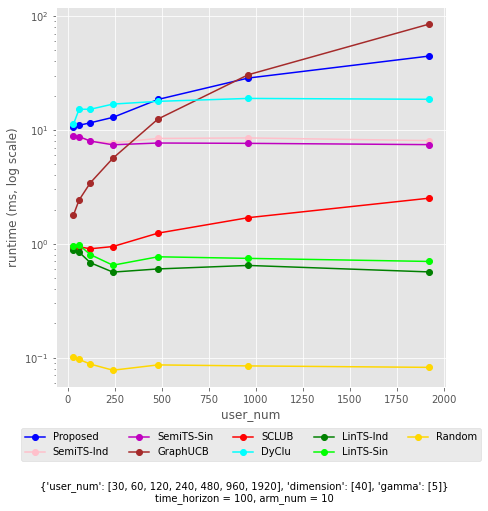

In [15]:
import math
import numpy.ma as ma

image = plt.figure(figsize=(7,7))
x = np.array(change_dict[change_val_name])

for i in range(len(model_list)):
    model = model_list[i]
    clr = colors_dict[model]
    lbl = labels_dict[model]

    #print(model, end=" ")
    runtime_mask = [ False if runtime!=0 else True for runtime in runtime_dict[model].values() ] # to avoid log(0)
    y_for_plot = ma.masked_array(np.array(list(runtime_dict[model].values())), mask = runtime_mask)
    x_for_plot = ma.masked_array(np.array(list(runtime_dict[model].keys())), mask = runtime_mask)
    plt.plot(x_for_plot, y_for_plot, marker='o',label=lbl, color = clr)

plt.xlabel(change_val_name)
plt.ylabel('runtime (ms, log scale)')
plt.yscale("log")
txt_change_dict = str(change_dict)
info_txt = txt_change_dict + "\ntime_horizon = " + str(time_horizon) +", arm_num = " + str(arm_num) # +", gamma = "+ str(gamma)

plt.legend(loc='center', bbox_to_anchor=(0.5,-0.15),fancybox=True, ncol=5)
plt.figtext(0.5, -0.1, info_txt, ha="center", fontsize=10)

IMG_FOLDER = "plot"
IMG_FOLDER_FOR_OS = current_dir+"/"+IMG_FOLDER
IMG_NAME = "runtime_changing("+ change_val_name +").png"
IMG_PATH = IMG_FOLDER+"/"+IMG_NAME

#-----
if not os.path.exists(IMG_FOLDER_FOR_OS):
    os.makedirs(IMG_FOLDER_FOR_OS)

SAVE = False
SAVE = True
if SAVE == True:
    image.savefig(IMG_PATH, bbox_inches='tight')
#-----

image.show()

# 2. Change dimension

In [16]:
# base: setting (i)
arm_num = 10
change_dict = {}
change_dict["user_num"] = [30] 
change_dict["dimension"] = diff_var["dimension"]
change_dict["gamma"] = [5]

change_val_name = "user_num" # just base value, no meaning
for key, val in change_dict.items():
    if len(val) > 1: # only one of "user_num", "dimension", "gamma" has the value with length > 1
        change_val_name = key
print(f"change_val_name = {change_val_name}")

model_list=["SemiRGraphTS", "IndividualSemiRidgeGraphThompson", "SemiTS_Single", "GraphUCBlocal", "SCLUB", "DyClu",  "LinTS", "LinTS_Single", "Random"]#model_list=["SemiRGraphTS", "IndividualSemiRidgeGraphThompson", "SemiTS_Single", "GraphUCBlocal", "SCLUB", "CLUB" ,"DyClu",  "LinTS", "LinTS_Single", "Random"]
runtime_dict={model:{i:0 for i in change_dict[change_val_name]} for model in model_list}

change_val_name = dimension


In [17]:
for user_num in change_dict["user_num"]:
    for dimension in change_dict["dimension"]:
        for gamma in change_dict["gamma"]: # only one of {user_num, dimension, gamma} is changing
            
            print(f"\nchange_val = {change_val_name} // user_num = {user_num} / dimension = {dimension} / gamma = {gamma}\n")
            #time.sleep(3)
            
            const_tol_1 = dimension
            const_tol_2 = const_tol_1 * 1e-5 

            # which value is changing?
            if change_val_name == "user_num":
                change_val = user_num
            elif change_val_name == "dimension":
                change_val = dimension
            elif change_val == "gamma":
                change_val = gamma
                
            # save runtime of each algorithms (as changing change_val)                
            if change_val_name == "gamma":
                pass        
            else:
                our_graph, our_laplacian, users_features, symm_laplacian = set_graph_and_lapl_for_experiment(user_num, dimension, prob, threshold, our_graph_type, lap_type, gamma)

                best_v_lam_pair_dict = {} # fix any v and lam as best pair (because we only want to know the computation time per round)
                for model in model_list:
                    best_v_lam_pair_dict[model] = {"v": v, "lam": lam} 

                cumulated_regret_dict, info_computing_time, info_computing_time_dict, record_runtime = RUNTIME_for_selected_model_SYNTH(model_list,\
                                                                                                                        best_v_lam_pair_dict, user_num, arm_num, dimension, time_horizon, const_R, delta, simul_n, epsilon, threshold, prob, gamma, our_graph, our_laplacian, symm_laplacian, const_alpha_2, const_tol_1, const_tol_2, nu_type, arm_type)
                              
                # save in runtime_dict
                for model in model_list:
                    runtime_dict[model][change_val] = info_computing_time_dict[model]    
                    record_runtime_dict[model][change_val] = record_runtime[model]


change_val = dimension // user_num = 30 / dimension = 10 / gamma = 5

<set models>
IndTS, time = 0.0005011558532714844 sec
SCLUB, time = 0.0009329319000244141 sec
DyClu, time = 0.00040078163146972656 sec
SemiRidegeTS, time = 0.0007538795471191406 sec
GUCBlocal, time = 0.0008318424224853516 sec
IndividualSemiRidgeGraphThompson, time = 0.0002148151397705078 sec
LinTS_Single, time = 1.9073486328125e-05 sec
SemiTS_Single, time = 1.621246337890625e-05 sec
0 user: 4 / selected arms: 0 -1 6 6 -1 -1 6 7 1 7 4 3 / opt_arm: 9 / time : 0.015 sec
=====
10 user: 5 / selected arms: 1 -1 0 8 -1 -1 8 9 6 2 2 6 / opt_arm: 4 / time : 0.013 sec
=====
20 user: 13 / selected arms: 4 -1 2 5 -1 -1 5 7 5 8 3 2 / opt_arm: 8 / time : 0.02 sec
=====
30 user: 2 / selected arms: 8 -1 7 9 -1 -1 9 8 6 4 1 9 / opt_arm: 4 / time : 0.016 sec
=====
40 user: 7 / selected arms: 4 -1 9 7 -1 -1 7 7 8 4 3 9 / opt_arm: 9 / time : 0.016 sec
=====
50 user: 19 / selected arms: 4 -1 8 9 -1 -1 9 6 4 6 9 7 / opt_arm: 4 / time : 0.

/home/shpaik/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: covariance is not positive-semidefinite.
/home/shpaik/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: covariance is not positive-semidefinite.


70 user: 4 / selected arms: 4 -1 8 4 -1 -1 4 2 7 9 8 6 / opt_arm: 3 / time : 31.075 sec
=====
80 user: 10 / selected arms: 7 -1 9 9 -1 -1 9 5 7 8 0 7 / opt_arm: 2 / time : 19.362 sec
=====
90 user: 18 / selected arms: 2 -1 1 8 -1 -1 8 1 2 8 8 0 / opt_arm: 1 / time : 16.336 sec
=====
iteration = 1/1, time = 2977.949 sec
Random: 0.0815 ms
RGraphTS: 0.0 ms
LinTS: 891.2643 ms
SCLUB: 271.1011 ms
slot4: 0.0 ms
CLUB: 0.0 ms
DyClu: 14587.8296 ms
SemiRGraphTS: 5055.8933 ms
GraphUCBlocal: 1150.326 ms
IndividualSemiRidgeGraphThompson: 3396.3837 ms
LinTS_Single: 935.4275 ms
SemiTS_Single: 3489.5004 ms
TOTAL TIME: 2977.9488 sec


In [18]:
for_final_plot_dict[change_val_name] = runtime_dict
record_for_final_plot_dict[change_val_name] = record_runtime_dict

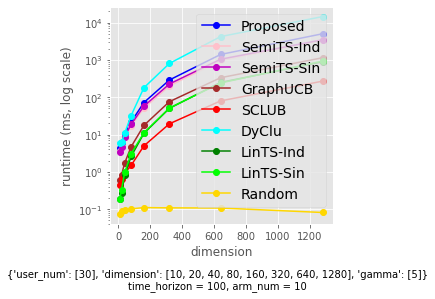

In [19]:
import math
import numpy.ma as ma

change_val_name = "dimension"
runtime_dict = for_final_plot_dict[change_val_name]

image = plt.figure(figsize=(4,4))
x = np.array(change_dict[change_val_name])

for i in range(len(model_list)):
    model = model_list[i]
    clr = colors_dict[model]
    lbl = labels_dict[model]

    #print(model, end=" ")
    runtime_mask = [ False if runtime!=0 else True for runtime in runtime_dict[model].values() ] # to avoid log(0)
    y_for_plot = ma.masked_array(np.array(list(runtime_dict[model].values())), mask = runtime_mask)
    x_for_plot = ma.masked_array(np.array(list(runtime_dict[model].keys())), mask = runtime_mask)
    plt.plot(x_for_plot, y_for_plot, marker='o',label=lbl, color = clr)

plt.xlabel(change_val_name)
plt.ylabel('runtime (ms, log scale)')
plt.yscale("log")
txt_change_dict = str(change_dict)
info_txt = txt_change_dict + "\ntime_horizon = " + str(time_horizon) +", arm_num = " + str(arm_num) # +", gamma = "+ str(gamma)

plt.legend(loc='best',fontsize=14)
plt.figtext(0.5, -0.1, info_txt, ha="center", fontsize=10)

#plt.tight_layout(rect=[0, 0.03, 1, 0.95])

IMG_FOLDER = "plot"
IMG_FOLDER_FOR_OS = current_dir+"/"+IMG_FOLDER
IMG_NAME = "runtime_changing("+ change_val_name +").png"
IMG_PATH = IMG_FOLDER+"/"+IMG_NAME

#-----
if not os.path.exists(IMG_FOLDER_FOR_OS):
    os.makedirs(IMG_FOLDER_FOR_OS)

SAVE = False
SAVE = True
if SAVE == True:
    image.savefig(IMG_PATH, bbox_inches='tight')
#-----

image.show()

# 3. Change number of arms

In [20]:
# base: setting (i)
gamma = 5
change_dict = {}
change_dict["user_num"] = [30] 
change_dict["dimension"] = [40]
change_dict["gamma"] = [5]
change_dict["arm_num"] = diff_var["arm_num"]

change_val_name = "arm_num" # just base value, no meaning
for key, val in change_dict.items():
    if len(val) > 1: # only one of "user_num", "dimension", "gamma" has the value with length > 1
        change_val_name = key
print(f"change_val_name = {change_val_name}")

model_list=["SemiRGraphTS", "IndividualSemiRidgeGraphThompson", "SemiTS_Single", "GraphUCBlocal", "SCLUB", "DyClu",  "LinTS", "LinTS_Single", "Random"]
runtime_dict={model:{i:0 for i in change_dict[change_val_name]} for model in model_list}

change_val_name = arm_num


In [21]:
for user_num in change_dict["user_num"]:
    for dimension in change_dict["dimension"]:
        for arm_num in change_dict["arm_num"]: # only one of {user_num, dimension, gamma} is changing
            
            print(f"\nchange_val = {change_val_name} // arm_num = {arm_num} / user_num = {user_num} / dimension = {dimension} / gamma = {gamma}\n")
            #time.sleep(3)
            
            const_tol_1 = dimension
            const_tol_2 = const_tol_1 * 1e-5 

            # which value is changing?
            if change_val_name == "user_num":
                change_val = user_num
            elif change_val_name == "dimension":
                change_val = dimension
            elif change_val == "gamma":
                change_val = gamma
            elif change_val_name == "arm_num":
                change_val = arm_num

                
            # save runtime of each algorithms (as changing change_val)                
            if change_val_name == "gamma":
                pass        
            else:
                our_graph, our_laplacian, users_features, symm_laplacian = set_graph_and_lapl_for_experiment(user_num, dimension, prob, threshold, our_graph_type, lap_type, gamma)

                best_v_lam_pair_dict = {} # fix any v and lam as best pair (because we only want to know the computation time per round)
                for model in model_list:
                    best_v_lam_pair_dict[model] = {"v": v, "lam": lam} 

                cumulated_regret_dict, info_computing_time, info_computing_time_dict, record_runtime = RUNTIME_for_selected_model_SYNTH(model_list,\
                                                                                                                        best_v_lam_pair_dict, user_num, arm_num, dimension, time_horizon, const_R, delta, simul_n, epsilon, threshold, prob, gamma, our_graph, our_laplacian, symm_laplacian, const_alpha_2, const_tol_1, const_tol_2, nu_type, arm_type="normal")
                              
                # save in runtime_dict
                for model in model_list:
                    runtime_dict[model][change_val] = info_computing_time_dict[model]    
                    record_runtime_dict[model][change_val] = record_runtime[model]


change_val = arm_num // arm_num = 8 / user_num = 30 / dimension = 40 / gamma = 5

<set models>
IndTS, time = 0.0005998611450195312 sec
SCLUB, time = 0.0008180141448974609 sec
DyClu, time = 0.00013303756713867188 sec
SemiRidegeTS, time = 0.0008215904235839844 sec
GUCBlocal, time = 0.0016100406646728516 sec
IndividualSemiRidgeGraphThompson, time = 0.000499725341796875 sec
LinTS_Single, time = 6.580352783203125e-05 sec
SemiTS_Single, time = 7.605552673339844e-05 sec
0 user: 5 / selected arms: 0 -1 3 1 -1 -1 1 7 3 0 6 1 / opt_arm: 7 / time : 0.018 sec
=====
10 user: 26 / selected arms: 1 -1 7 1 -1 -1 2 1 1 1 4 6 / opt_arm: 0 / time : 0.018 sec
=====
20 user: 27 / selected arms: 6 -1 3 1 -1 -1 4 6 4 7 3 1 / opt_arm: 7 / time : 0.021 sec
=====
30 user: 4 / selected arms: 6 -1 2 0 -1 -1 7 7 6 5 4 3 / opt_arm: 3 / time : 0.022 sec
=====
40 user: 1 / selected arms: 2 -1 6 3 -1 -1 7 0 5 2 1 3 / opt_arm: 3 / time : 0.025 sec
=====
50 user: 11 / selected arms: 2 -1 2 0 -1 -1 4 0 7 5 4 1 / opt_arm

In [22]:
for_final_plot_dict[change_val_name] = runtime_dict
record_for_final_plot_dict[change_val_name] = record_runtime_dict
#print(for_final_plot_dict)
#print(record_for_final_plot_dict)

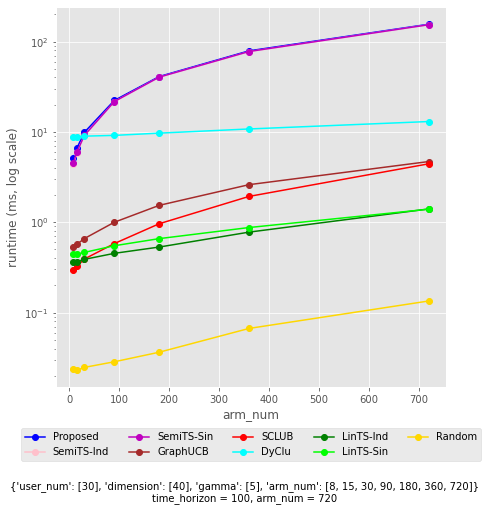

In [23]:
import math
import numpy.ma as ma

change_val_name = "arm_num"
runtime_dict = for_final_plot_dict[change_val_name]

image = plt.figure(figsize=(7,7))
x = np.array(change_dict[change_val_name])

for i in range(len(model_list)):
    model = model_list[i]
    clr = colors_dict[model]
    lbl = labels_dict[model]

    #print(model, end=" ")
    runtime_mask = [ False if runtime!=0 else True for runtime in runtime_dict[model].values() ] # to avoid log(0)
    y_for_plot = ma.masked_array(np.array(list(runtime_dict[model].values())), mask = runtime_mask)
    x_for_plot = ma.masked_array(np.array(list(runtime_dict[model].keys())), mask = runtime_mask)
    plt.plot(x_for_plot, y_for_plot, marker='o',label=lbl, color = clr)

plt.xlabel(change_val_name)
plt.ylabel('runtime (ms, log scale)')
plt.yscale("log")
txt_change_dict = str(change_dict)
info_txt = txt_change_dict + "\ntime_horizon = " + str(time_horizon) +", arm_num = " + str(arm_num) # +", gamma = "+ str(gamma)

plt.legend(loc='center', bbox_to_anchor=(0.5,-0.15),fancybox=True, ncol=5)
plt.figtext(0.5, -0.1, info_txt, ha="center", fontsize=10)

IMG_FOLDER = "plot"
IMG_FOLDER_FOR_OS = current_dir+"/"+IMG_FOLDER
IMG_NAME = "runtime_changing("+ change_val_name +").png"
IMG_PATH = IMG_FOLDER+"/"+IMG_NAME

#-----
if not os.path.exists(IMG_FOLDER_FOR_OS):
    os.makedirs(IMG_FOLDER_FOR_OS)

SAVE = False
SAVE = True
if SAVE == True:
    image.savefig(IMG_PATH, bbox_inches='tight')
#-----

image.show()

# Final plot

Random
SemiRGraphTS
IndividualSemiRidgeGraphThompson
SemiTS_Single
GraphUCBlocal
SCLUB
DyClu
LinTS
LinTS_Single
Random
SemiRGraphTS
IndividualSemiRidgeGraphThompson
SemiTS_Single
GraphUCBlocal
SCLUB
DyClu
LinTS
LinTS_Single
Random
SemiRGraphTS
IndividualSemiRidgeGraphThompson
SemiTS_Single
GraphUCBlocal
SCLUB
DyClu
LinTS
LinTS_Single


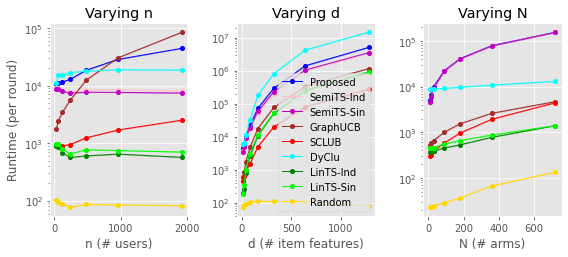

In [28]:
model_list=["SemiRGraphTS", "IndividualSemiRidgeGraphThompson", "SemiTS_Single", "GraphUCBlocal", "SCLUB", "DyClu",  "LinTS", "LinTS_Single", "Random"]
color_list=['y','r','g', 'r','m', 'aqua','blue','brown','pink']
change_list = ["user_num", "dimension", "arm_num"]

plt.close('all')
figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,4))

for k in range(3):
    image = ax[k]
    change_val_name = change_list[k]
    runtime_dict = for_final_plot_dict[change_val_name]
    record_runtime_dict = for_final_plot_dict[change_val_name] 
    #print(record_runtime_list)
    
    for i in range(len(model_list)):
        
        print(model)
        model = model_list[i]        
        clr = colors_dict[model]
        lbl = labels_dict[model]
                
        y_lower = {var:1000*(np.mean(np.array(record_runtime_dict[model][var])) - 1.96 * np.std(np.array(record_runtime_dict[model][var]))/10) for var in diff_var[change_val_name]}
        y_upper = {var:1000*(np.mean(np.array(record_runtime_dict[model][var])) + 1.96 * np.std(np.array(record_runtime_dict[model][var]))/10) for var in diff_var[change_val_name]}
        #y_med = {var:1000*np.percentile(np.array(record_runtime_dict[model][var]), 50) for var in diff_var[change_val_name]}
        y_mean = {var:1000*np.mean(np.array(record_runtime_dict[model][var])) for var in diff_var[change_val_name]}
        # 1000: sec to ms
        
        x = diff_var[change_val_name]
        image.plot(x, list(y_mean.values()), marker='o', linewidth = 1, label=lbl, color = clr, ms=4)
        image.fill_between(x, list(y_lower.values()), list(y_upper.values()), color = clr, alpha=0.3)
    
    if change_val_name == "user_num":
        ax[k].set(xlabel = "n (# users)", ylabel = "Runtime (per round)")
        ax[k].set_title("Varying n")
    if change_val_name == "dimension":
        ax[k].set_title("Varying d")
        ax[k].set(xlabel = "d (# item features)")
    if change_val_name == "arm_num":
        ax[k].set_title("Varying N")
        ax[k].set(xlabel = "N (# arms)")

        
    image.set_yscale("log")

#ax[2].legend(loc="lower right", fontsize = 11)
ax[1].legend(loc="best", fontsize = 10)
figure.tight_layout(rect=[0, 0.03, 1, 0.95])

#---
IMG_FOLDER = "plot"
IMG_FOLDER_FOR_OS = current_dir+"/"+IMG_FOLDER
IMG_NAME = "Fig3"+".pdf"
IMG_PATH = IMG_FOLDER+"/"+IMG_NAME
#-----
if not os.path.exists(IMG_FOLDER_FOR_OS):
    os.makedirs(IMG_FOLDER_FOR_OS)

SAVE = True # False
if SAVE == True:
    figure.savefig(IMG_PATH, bbox_inches='tight')
#-----
figure.show()

# MISC

In [25]:
change_val_name

'arm_num'

In [26]:
diff_var["arm_num"]

[8, 15, 30, 90, 180, 360, 720]

In [27]:
record_runtime_dict["CLUB"][1920]

KeyError: 'CLUB'

In [ ]:
len(record_runtime_dict["GraphUCBlocal"])

In [ ]:
record_runtime_dict["SemiRGraphTS"].keys()

In [ ]:
record_runtime_dict["GraphUCBlocal"].values()